In [5]:
from salad.cluster import Clusters
from salad.serialize import Serializable

In [352]:
clusters = Clusters.read("/epyc/projects/salad/search/DEEP/20190403/A0c/detector_1/snr_5/gather_2.pkl")
catalog = Serializable.read("/epyc/projects/salad/search/DEEP/20190403/A0c/detector_1/snr_5/catalog.pkl")
pg_fakes = Serializable.read("/epyc/projects/salad/search/DEEP/20190403/A0c/fakes.pkl")
detector_fakes = Serializable.read("/epyc/projects/salad/search/DEEP/20190403/A0c/detector_1/fakes.pkl")
hough = Serializable.read("/epyc/projects/salad/search/DEEP/20190403/A0c/detector_1/snr_5/hough.pkl")

In [181]:
hough.projection.directions.b

<Quantity [[-0.4844277 ,  0.01388589],
           [-0.4688554 ,  0.01388589],
           [-0.4532831 ,  0.01388589],
           ...,
           [-0.2352709 ,  0.40319339],
           [-0.2664155 ,  0.41876568],
           [-0.2508432 ,  0.41876568]] deg / d>

In [322]:
# loop over exposures

def detections_in_catalog(fakes, catalog, match_threshold=1 * u.arcsec):
    exposures = set(fakes['EXPNUM'])
    orbits = set(fakes['ORBITID'])
    catalog_coords = SkyCoord(catalog.ra, catalog.dec)
    catalog_exposures = catalog.exposure
    recoveries = {orbit: 0 for orbit in orbits}
    for exposure in exposures:
        exposure_catalog_coords = catalog_coords[catalog_exposures == exposure]
        exposure_fakes = fakes[fakes['EXPNUM'] == exposure]
        exposure_fakes_coords = SkyCoord(exposure_fakes['RA'] * u.deg, exposure_fakes['DEC'] * u.deg)
        for fake, fake_coord in zip(exposure_fakes, exposure_fakes_coords):
            sep = fake_coord.separation(exposure_catalog_coords)
            matches = sep < match_threshold
            num_matches = matches.sum()
            if num_matches > 0:
                recoveries[fake['ORBITID']] += num_matches
                
    return recoveries

findable_detections = detections_in_catalog(detector_fakes, catalog)          
    
def velocity_in_hough(fakes, hough):
    b = hough.projection.directions.b
    recoveries = {}
    for orbit in fakes.group_by("ORBITID").groups:
        dt = (orbit['mjd_mid'][-1] - orbit['mjd_mid'][0]) * u.day

        if dt == 0:
            vra = np.nan
            vdec = np.nan
        else:
            dra = (orbit['RA'][-1] - orbit['RA'][0]) * u.deg
            ddec = (orbit['DEC'][-1] - orbit['DEC'][0]) * u.deg
            vra = dra / dt
            vdec = ddec / dt
        
        dv = b - np.array([vra.value, vdec.value]) * u.deg/u.day
        min_dv = ((dv**2).sum(axis=1)**0.5).min()
        distance = min_dv * dt        
        recoveries[orbit[0]['ORBITID']] = (distance < hough.dx * u.deg)
    
    return recoveries
    
findable_velocity = velocity_in_hough(detector_fakes, hough)

# print(findable_detections, findable_velocity)
findable = {}
for orbit in findable_detections:
    findable[orbit] = (findable_detections[orbit] > 25) and (findable_velocity[orbit])

findable
# exposure_catalog = catalog.X()[catalog.exposure]

{13039521: False,
 10564514: False,
 14621325: True,
 10053463: False,
 13776855: True,
 14813564: False,
 10041343: False}

In [330]:
@lru_cache(maxsize=512)
def match_time_to_exposure(t, catalog):
    e = list(set(catalog.exposure[np.abs(catalog.time - t) < 1/(24*60*60)]))
    return e

In [334]:
from salad.gather import gather

In [333]:
def recover(fakes, clusters, catalog, match_threshold=1 * u.arcsec):
    """
    What I want to know is for each fake:
    - how many clusters did it appear in
    - which clusters did it appear in
    - how often did it appear in those clusters?
    The problem is that the match is on ra/dec/time but the connection is only implicit
    unless the catalog is provided
    """
    recoveries = {}
    for orbit in fakes.group_by("ORBITID").groups:
        fake_coords = SkyCoord(orbit['RA'] * u.deg, orbit['DEC'] * u.deg)

        fakes_lookup = {}
        recovery = {}
        for i, cluster in enumerate(clusters):
            for x, y, t in cluster.points:
                exposure = match_time_to_exposure(t, catalog)[0]
                if exposure not in fakes_lookup:
                    fakes_lookup[exposure] = fake_coords[orbit['EXPNUM'] == exposure]

            cluster_coords = SkyCoord(cluster.points[:, 0] * u.deg, cluster.points[:, 1] * u.deg)
            fakes_in_cluster = 0
            for j, (coord, t) in enumerate(zip(cluster_coords, cluster.points[:, 2])):
                exposure = match_time_to_exposure(t, catalog)[0]
                fake_coord = fakes_lookup[exposure]
                if len(fake_coord) == 0:
                    continue

                if len(fake_coord) > 1:
                    print(orbit_id, exposure, len(fake_coord))
                    
                fake_coord = fake_coord[0]
                sep = fake_coord.separation(coord)
                if sep < match_threshold:
                    fakes_in_cluster += 1

            if fakes_in_cluster != 0:
                recovery[i] = fakes_in_cluster
        recoveries[orbit[0]['ORBITID']] = recovery

    return recoveries

fake_recoveries = recover(detector_fakes, clusters, catalog)

In [372]:
def _recover(fakes, clusters, catalog, match_threshold=1 * u.arcsec, sky_units=u.deg, time_units=u.day):
    exposures = set(fakes['EXPNUM'])
    orbits = set(fakes['ORBITID'])
    
    X = catalog.X(columns=["ra", "dec", "time"], sky_units=sky_units, time_units=time_units)

    ra = X[:, 0] * sky_units
    dec = X[:, 1] * sky_units
    time = X[:, 2] * time_units
    
    catalog_coords = SkyCoord(catalog.ra, catalog.dec)
    catalog_exposures = catalog.exposure
    catalog_times = catalog.time
    recoveries = {orbit: {} for orbit in orbits}
    
    for exposure in exposures:
        catalog_mask = catalog_exposures == exposure
        exposure_catalog_coords = catalog_coords[catalog_mask]
        exposure_catalog_times = catalog_times[catalog_mask]
        exposure_fakes = fakes[fakes['EXPNUM'] == exposure]
        exposure_fakes_coords = SkyCoord(exposure_fakes['RA'] * u.deg, exposure_fakes['DEC'] * u.deg)
        for fake, fake_coord in zip(exposure_fakes, exposure_fakes_coords):
            for i, cluster in enumerate(clusters):
                line = cluster.extra['line']
                ra = exposure_catalog_coords.ra
                dec = exposure_catalog_coords.dec
                times = exposure_catalog_times.value * u.day
#                 print(line.beta.unit, line.alpha.unit, times.unit)
#                 print(np.dot(times[:, None] * u.day, line.beta).unit)
#                 print(np.dot(times[:, None], line.beta) + line.alpha)
                cluster_mask = gather(line, ra, dec, times, match_threshold)
                cluster_coords = exposure_catalog_coords[cluster_mask]

                sep = fake_coord.separation(cluster_coords)
                matches = sep < match_threshold
                num_matches = matches.sum()
                if num_matches > 0:
                    if i not in recoveries[fake['ORBITID']]:
                        recoveries[fake['ORBITID']][i] = num_matches
                    else:
                        recoveries[fake['ORBITID']][i] += num_matches
    
    return recoveries
            
_recover(detector_fakes, clusters, catalog)


KeyboardInterrupt



In [355]:
times

NameError: name 'times' is not defined

In [318]:

            
#         velocity_distance = np.array(
#             [
#                 (((b.value - np.array([d['vra'], d['vdec']]).T[i])**2).sum(axis=1)**0.5).min() for i in range(len(d))
#             ]
#         )
#         dt = catalog.time.max() - catalog.time.min()

#         velocity_detectable = (velocity_distance * dt) < dx

    

0.019610380472733942 deg 0.002777777777777778
0.002254669904436475 deg 0.002777777777777778
0.0002708780890078896 deg 0.002777777777777778
0.001890712914422751 deg 0.002777777777777778
0.00010674737135013097 deg 0.002777777777777778
0.001274499346653099 deg 0.002777777777777778
0.005704030264465074 deg 0.002777777777777778


{10041343: False,
 10053463: True,
 10564514: True,
 13039521: True,
 13776855: True,
 14621325: True,
 14813564: False}

In [ ]:
from astropy.coordinates import SkyCoord

def recover_fake(orbit_id, pg_fakes, search_exposures, points, results, match_threshold):
    search_separations = dict()
    search_detect = dict()
    result_separations = dict()
    result_detect = dict()
    
    fake = pg_fakes[pg_fakes['ORBITID'] == orbit_id]
    fake_coords = SkyCoord(fake['RA'] * u.deg, fake['DEC'] * u.deg)

    search_separations[orbit_id] = []
    search_detect[orbit_id] = 0

    result_separations[orbit_id] = [[] for result in results]
    result_detect[orbit_id] = [0 for result in results]
    
    for i, expnum in enumerate(fake['EXPNUM']):
        fake_coord = fake_coords[i]        
        search_mask = search_exposures == expnum
        search_points = points[search_mask]
        search_coords = SkyCoord(search_points[:, 0] * u.deg, search_points[:, 1] * u.deg)
        
        search_separation = fake_coord.separation(search_coords)
        search_match = (search_separation < match_threshold).sum()
        
        search_separations[orbit_id].append(search_separation)
        search_detect[orbit_id] += search_match
        for j, result in enumerate(results):
            
            result_mask = search_mask & result.close
            result_points = points[result_mask]
            result_coords = SkyCoord(result_points[:, 0] * u.deg, result_points[:, 1] * u.deg)
            result_separation = fake_coord.separation(result_coords)
            result_match = (result_separation < match_threshold).sum()

            result_separations[orbit_id][j].append(result_separation)
            result_detect[orbit_id][j] += result_match
            
    return search_separations, search_detect, result_separations, result_detect

In [55]:
from astropy.coordinates import SkyCoord
import astropy.units as u

from functools import lru_cache
import numpy as np

@lru_cache(maxsize=512)
def match_time_to_exposure(t):
    e = list(set(catalog.exposure[np.abs(catalog.time - t) < 1/(24*60*60)]))
    return e

def recover_fake(orbit_id, pg_fakes, clusters, match_threshold):
    fake = pg_fakes[pg_fakes['ORBITID'] == orbit_id]
    fake_coords = SkyCoord(fake['RA'] * u.deg, fake['DEC'] * u.deg)
    
    fakes_lookup = {}
    recovery = []
    for i, cluster in enumerate(clusters):
        for x, y, t in cluster.points:
            exposure = match_time_to_exposure(t)[0]
            if exposure not in fakes_lookup:
                fakes_lookup[exposure] = fake_coords[fake['EXPNUM'] == exposure]
                
        cluster_coords = SkyCoord(cluster.points[:, 0] * u.deg, cluster.points[:, 1] * u.deg)
        fakes_in_cluster = []
        for j, (coord, t) in enumerate(zip(cluster_coords, cluster.points[:, 2])):
            exposure = match_time_to_exposure(t)[0]
            fake_coord = fakes_lookup[exposure]
            if len(fake_coord) == 0:
                continue
                
            if len(fake_coord) > 1:
                print(orbit_id, exposure, len(fake_coord))
            fake_coord = fake_coord[0]
            sep = fake_coord.separation(coord)
            if sep < match_threshold:
                fakes_in_cluster.append((j, sep))
        
        recovery.append((i, fakes_in_cluster))
    return recovery

recoveries = {}
for orbit in orbits:
    recoveries[orbit] = recover_fake(orbit, pg_fakes, clusters, 1 * u.arcsec)

In [51]:
pg_fakes[pg_fakes['EXPNUM'] == 845964]

RA,DEC,EXPNUM,CCDNUM,ORBITID,aei,mjd_mid,TDB,xv,H_VR,AMP,PERIOD,PHASE,d,observatory,r,MAG,type
float64,float64,int32,int64,int64,float64[6],float64,float64,float64[6],float64,float64,float64,float64,float64,float64[3],float64,float64,str8
-143.72515360926803,-11.13808494705934,845964,1,10564514,4.744124923146405 .. 21.15054193472637,58577.373972736634,19.254961734419567,-3.9446562712288027 .. 1.0989200778250192,19.875462693294573,0.0173926475058557,665.1169914409637,3.20855259336801,4.646544109961093,-0.9716704729591126 .. -0.09358920446535941,3.7109126924668128,26.04136522995194,asteroid
-143.96908432447114,-10.994978659780088,845964,1,13776855,4.604960583603774 .. 19.027256220603515,58577.373972736634,19.254961734419567,-3.240235124428043 .. 1.2445952448359225,18.916147877038295,0.26535089794784933,851.2908017572711,5.8763359899807295,3.755567515775062,-0.9716704729591126 .. -0.09358920446535941,2.8133556769716117,23.771487179199987,asteroid
-143.80759095927417,-11.073198297661213,845964,1,10041343,2.71111629178837 .. 18.41855787530429,58577.373972736634,19.254961734419567,-2.421571146054563 .. -3.3211997804200095,19.121154628476752,0.0,0.0,0.0,2.676662924050746,-0.9716704729591126 .. -0.09358920446535941,1.7135546013824714,22.428612782624107,asteroid
-143.81071329919916,-11.005962049344202,845964,1,14813564,4.813582190291083 .. 24.47630699787191,58577.373972736634,19.254961734419567,-4.2334007729886745 .. -2.425249823115864,17.626607257093205,0.0,0.0,0.0,5.032794602017321,-0.9716704729591126 .. -0.09358920446535941,4.102020766150644,24.200642562035306,asteroid
-143.99750185305268,-10.998971037671753,845964,1,14621325,3.3506836355032688 .. 22.67246972153699,58577.373972736634,19.254961734419567,-3.4520510587674966 .. 0.9691793650608819,16.526482038360356,0.29709236982204834,608.5974010286963,3.997664281811296,4.027506743554383,-0.9716704729591126 .. -0.09358920446535941,3.0883013650925264,21.719748640176956,asteroid
-143.74540805601396,-11.038597890286113,845964,1,10053463,4.185269708901746 .. 16.603446020387388,58577.373972736634,19.254961734419567,-3.6796048133265034 .. -1.9714708319724865,19.685265063034933,0.05371919848692803,709.6072870435283,5.868276430380363,4.3253985709038005,-0.9716704729591126 .. -0.09358920446535941,3.390066223050467,25.50263690102504,asteroid
-143.8115003619338,-11.113263959776601,845964,1,13039521,4.483972210804367 .. 17.968228701022632,58577.373972736634,19.254961734419567,-3.7826960678926653 .. -1.9254621127723786,20.142308663612436,0.28363515991182864,1047.0235301096193,4.516134697461962,4.4524355789577745,-0.9716704729591126 .. -0.09358920446535941,3.5173896508776874,26.350221709239722,asteroid


In [191]:
orbit_recoveries = {}
for orbit in recoveries:
    recovered_clusters = list(filter(lambda x : len(x[1]) > 0, recoveries[orbit]))
    num_clusters = len(recovered_clusters)
    num_per_cluster = list(map(lambda x : (x[0], len(x[1])), recovered_clusters))
    num_detected = sum(map(lambda x : x[1], num_per_cluster))
    purity = list(map(lambda x : (x[0], x[1]/num_detected), num_per_cluster))
#     num_clusters = sum(map(lambda x : len(x[1]) > 0, recoveries[orbit]))
#     num_detected = sum(map(lambda x : len(x[1]), recoveries[orbit]))
#     clusters = list(map(lambda x : x[0], filter(lambda x : len(x[1]) > 0, recoveries[orbit])))
    
    print(orbit, num_clusters, num_per_cluster, num_detected, purity)
    orbit_recoveries[orbit] = dict(
        num_clusters=num_clusters, 
        num_per_cluster=num_per_cluster, 
        num_detected=num_detected, 
        purity=purity,
    )
orbit_recoveries

13039521 0 [] 0 []
10564514 0 [] 0 []
14621325 1 [(6, 85)] 85 [(6, 1.0)]
10053463 0 [] 0 []
13776855 2 [(16, 47), (94, 2)] 49 [(16, 0.9591836734693877), (94, 0.04081632653061224)]
14813564 0 [] 0 []
10041343 0 [] 0 []


{13039521: {'num_clusters': 0,
  'num_per_cluster': [],
  'num_detected': 0,
  'purity': []},
 10564514: {'num_clusters': 0,
  'num_per_cluster': [],
  'num_detected': 0,
  'purity': []},
 14621325: {'num_clusters': 1,
  'num_per_cluster': [(6, 85)],
  'num_detected': 85,
  'purity': [(6, 1.0)]},
 10053463: {'num_clusters': 0,
  'num_per_cluster': [],
  'num_detected': 0,
  'purity': []},
 13776855: {'num_clusters': 2,
  'num_per_cluster': [(16, 47), (94, 2)],
  'num_detected': 49,
  'purity': [(16, 0.9591836734693877), (94, 0.04081632653061224)]},
 14813564: {'num_clusters': 0,
  'num_per_cluster': [],
  'num_detected': 0,
  'purity': []},
 10041343: {'num_clusters': 0,
  'num_per_cluster': [],
  'num_detected': 0,
  'purity': []}}

In [78]:
clusters.clusters[6].extra['line'].beta

<Quantity [[-0.1489325 ,  0.15267518]] deg / d>

In [79]:
clusters.clusters[16].extra['line'].beta

<Quantity [[-0.12583241,  0.18503595]] deg / d>

In [80]:
clusters.clusters[94].extra['line'].beta

<Quantity [[-0.10722523,  0.02939451]] deg / d>

In [148]:
import matplotlib.pyplot as plt

def plot_cluster(cluster, **kwargs):
    p = cluster.points
    x, y = p[:, 2][:, None], p[:, :2]
#     regression_result = regression(x, y)
    coord = (SkyCoord(y[:, 0] * u.deg, y[:, 1] * u.deg))
    plt.scatter(coord.ra, coord.dec, **kwargs)

def plot_result(result, x, **kwargs):
    _x = np.linspace(x.min(), x.max(), 100)[:, None] * result.alpha.unit / result.beta.unit
    _y = _x @ result.beta + result.alpha
    coord = (SkyCoord(_y[:, 0], _y[:, 1]))
    plt.plot(coord.ra, coord.dec, **kwargs)
    
def plot_fake(orbit, fakes, **kwargs):
    r = fakes[fakes['ORBITID'] == orbit]
    
    coord = (SkyCoord(r['RA'] * u.deg, r['DEC'] * u.deg))
    plt.scatter(coord.ra, coord.dec, **kwargs)
#     plt.title(str(o) + " VR~" + str(r['H_VR'][0]))

def plot_catalog(catalog, **kwargs):
    coord = (SkyCoord(catalog.ra, catalog.dec))
    
    plt.scatter(coord.ra, coord.dec, **kwargs)

In [ ]:
# for each fake, I should calculate
# how often it was injected
# how often it appeared in the detection catalog
# its on-sky velocity
# these can determine "findability"

In [195]:
catalog_coords = {}
for expnum in set(detector_fakes['EXPNUM']):
    catalog_coords[expnum] = SkyCoord(
        catalog.ra[catalog.exposure == expnum],
        catalog.dec[catalog.exposure == expnum],
    )


d = []
for orbit in detector_fakes.group_by("ORBITID").groups:
    orbit.sort("EXPNUM")
    n = len(orbit)
    dt = orbit['mjd_mid'][-1] - orbit['mjd_mid'][0]
    if dt == 0:
        vra = np.nan
        vdec = np.nan
    else:
        dra = orbit['RA'][-1] - orbit['RA'][0]
        ddec = orbit['DEC'][-1] - orbit['DEC'][0]
        vra = dra / dt
        vdec = ddec / dt


    in_catalog = 0
    for row in orbit:
        coord = SkyCoord(row['RA']*u.deg, row['DEC']*u.deg)
        sep = coord.separation(catalog_coords[row['EXPNUM']])
        matches = sep < 1 * u.arcsec
        in_catalog += matches.sum()
        
    recovered_clusters = list(filter(lambda x : len(x[1]) > 0, recoveries[orbit[0]['ORBITID']]))
    num_clusters = len(recovered_clusters)
    num_per_cluster = list(map(lambda x : (x[0], len(x[1])), recovered_clusters))
    num_detected = sum(map(lambda x : x[1], num_per_cluster))
    purity = list(map(lambda x : (x[0], x[1]/num_detected), num_per_cluster))
    max_purity = 0
    for x in purity:
        max_purity = max(x[1], max_purity)
        
    d.append(
        dict(
            ORBITID=orbit[0]['ORBITID'], 
            MAG=orbit[0]['MAG'], 
            n=n, 
            vra=vra, 
            vdec=vdec, 
            in_catalog=in_catalog,
            num_clusters=num_clusters,
            num_detected=num_detected,
            max_purity=max_purity,
        )
    )
d = astropy.table.Table(d)

In [196]:
d

ORBITID,MAG,n,vra,vdec,in_catalog,num_clusters,num_detected,max_purity
int64,float64,int64,float64,float64,int64,int64,int64,float64
10041343,22.42943705005781,104,-0.29713809493156784,-0.09604963855455591,100,0,0,0.0
10053463,25.519660320084146,104,-0.15100897047828574,0.0029864641685746636,0,0,0,0.0
10564514,26.041395418882704,21,-0.11873688880838078,0.12091516029456924,0,0,0,0.0
13039521,26.39768282519579,104,-0.14286354030928058,0.0033363187450130703,0,0,0,0.0
13776855,23.799304654954085,104,-0.1256695303635021,0.18511983953004849,47,2,49,0.9591836734693877
14621325,21.755897962503614,104,-0.14885474993460884,0.1526942159246714,85,1,85,1.0
14813564,24.2012042804041,104,-0.16369936876236016,-0.017466331230992248,7,0,0,0.0


In [204]:
catalog.num_times

104

In [288]:
velocity_distance = np.array(
    [(((b.value - np.array([d['vra'], d['vdec']]).T[i])**2).sum(axis=1)**0.5).min() for i in range(len(d))]
)
dt = catalog.time.max() - catalog.time.min()

velocity_detectable = (velocity_distance * dt * 3600) < 10
catalog_detectable = d['in_catalog'] > catalog.num_times / 4

detectable = velocity_detectable & catalog_detectable

In [289]:
detectable

array([False, False, False, False,  True,  True, False])

In [252]:
np.diag(np.subtract.outer(b.value, np.array([d['vra'], d['vdec']]))[0, :, :, 0])

array([-0.18728961,  0.10993553])

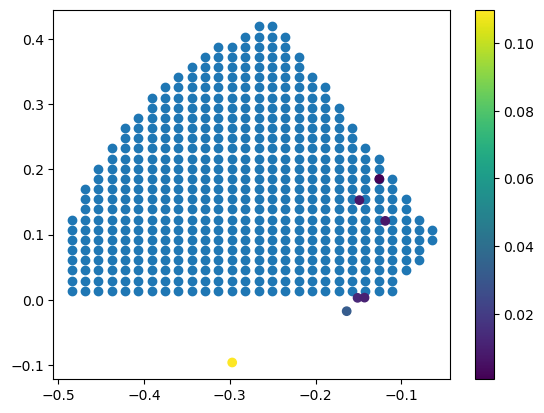

In [277]:
b = hough.projection.directions.b
plt.scatter(b[:, 0], b[:, 1])
# plt.scatter(d['vra'], d['vdec'], c=d['in_catalog']/d['n'])
plt.scatter(d['vra'], d['vdec'], c=distance)
plt.colorbar()
plt.show()

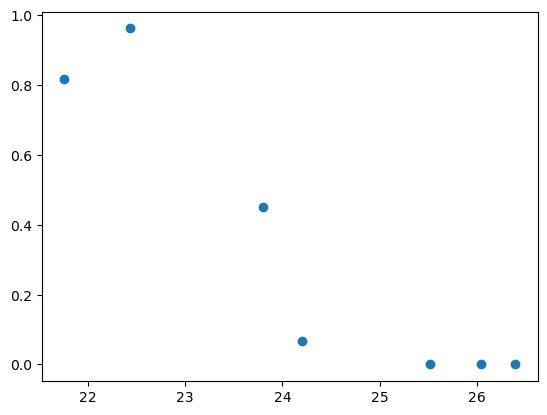

In [175]:
import astropy.table
d = astropy.table.Table(d)
plt.scatter(d['MAG'], d['in_catalog']/d['n'])
plt.show()

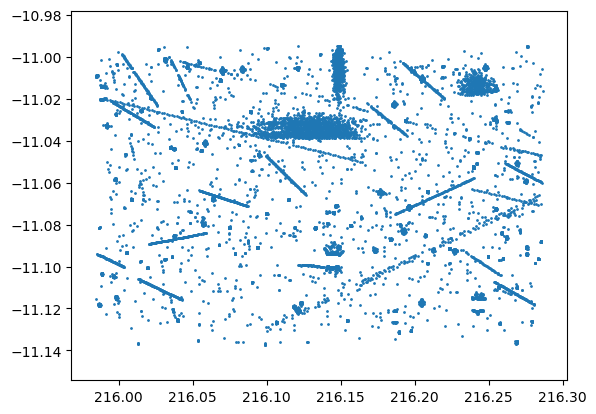

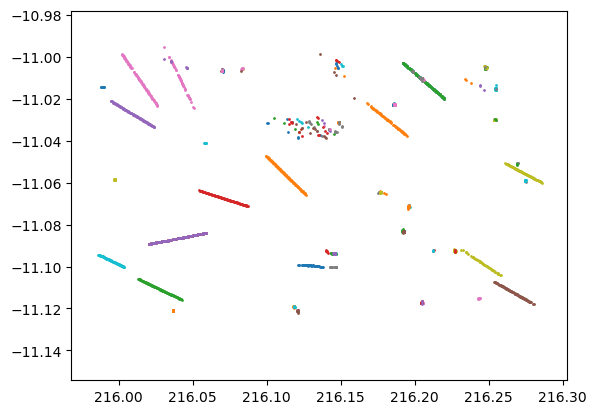

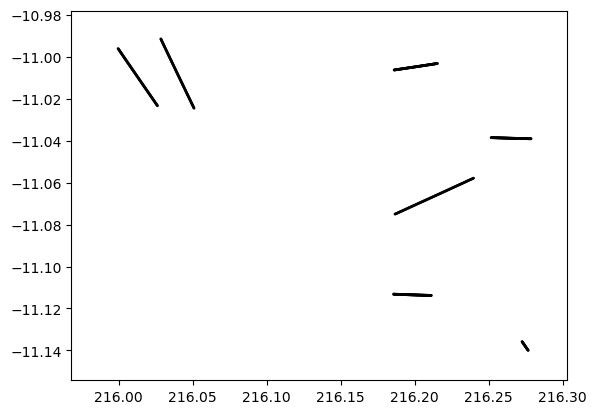

In [165]:
fig = plt.figure()
plot_catalog(catalog, s=1)
plt.xlim(catalog.ra.to(u.deg).min().value - 60/3600, catalog.ra.to(u.deg).max().value + 60/3600)
plt.ylim(catalog.dec.to(u.deg).min().value - 60/3600, catalog.dec.to(u.deg).max().value + 60/3600)
plt.show()

fig = plt.figure()
for cluster in clusters:
    plot_cluster(cluster, s=1)
    
plt.xlim(catalog.ra.to(u.deg).min().value - 60/3600, catalog.ra.to(u.deg).max().value + 60/3600)
plt.ylim(catalog.dec.to(u.deg).min().value - 60/3600, catalog.dec.to(u.deg).max().value + 60/3600)
plt.show()

fig = plt.figure()    
for orbit in set(pg_fakes['ORBITID']):
    plot_fake(orbit, pg_fakes, facecolors='none', edgecolors='k', s=1)
    
plt.xlim(catalog.ra.to(u.deg).min().value - 60/3600, catalog.ra.to(u.deg).max().value + 60/3600)
plt.ylim(catalog.dec.to(u.deg).min().value - 60/3600, catalog.dec.to(u.deg).max().value + 60/3600)
plt.show()

In [147]:
SkyCoord(
    orbit['RA']*u.deg, 
    orbit['DEC']*u.deg
).separation(
    catalog_coords[845872]
)

ValueError: operands could not be broadcast together with shapes (129,) (104,) 

In [141]:
coord.separation(catalog_coords[845872]).to(u.arcsec)

<Angle [812.21415236, 700.87020457, 694.13290851, 692.18802737,
        683.60643571, 678.93355851, 756.90952079, 690.93218387,
        665.44305712, 708.38523413, 607.25201491, 657.94077398,
        585.0256354 , 608.82727423, 546.04748558, 551.71060964,
        670.18173578, 596.25902634, 548.31695993, 671.95955982,
        513.75278815, 493.22451732, 492.47783468, 490.23775915,
        509.09812014, 585.93831871, 481.97587664, 526.99245944,
        467.01507448, 472.61663608, 463.75844289, 484.58933093,
        409.11185892, 410.95043117, 405.17849258, 365.56105327,
        361.51647769, 356.78613609, 363.37983538, 352.79382365,
        339.42510897, 287.39056966, 267.97324278, 267.94932168,
        260.39087528, 473.45000336, 258.40076796, 229.77467118,
        249.37328118, 472.94477272, 458.00011216, 220.96647946,
        330.15403176, 194.73619058, 291.57125528, 288.41156328,
        370.88505054, 366.46830753, 367.0057594 , 368.43814995,
        150.13926376, 144.11851128, 148.

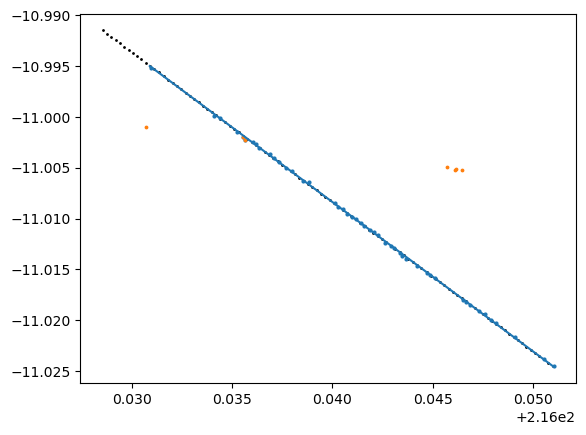

In [123]:
plot_fake(13776855, pg_fakes, s=1, c='k')
plot_cluster(clusters.clusters[16], s=4)
plot_cluster(clusters.clusters[94], s=3)
plot_result(clusters.clusters[16].extra['line'], clusters.clusters[16].points[:, 2])

In [18]:
cluster = next(iter(clusters))

In [37]:
import numpy as np

for t in cluster.points[:, 2]:
    e = match_time_to_exposure(t)
    print(t, e)

58577.236239315476 [845884]
58577.26024303492 [845898]
58577.31930518523 [845932]
58577.32617918216 [845936]
58577.2935738028 [845917]
58577.22251877701 [845876]
58577.21909338422 [845874]
58577.35574921034 [845953]
58577.28477227222 [845912]
58577.26367424941 [845900]
58577.36953355977 [845961]
58577.393984940834 [845975]
58577.22080451343 [845875]
58577.32789804274 [845937]
58577.243096433114 [845888]
58577.2744987444 [845906]
58577.35231478186 [845951]
58577.376813050825 [845965]
58577.309025622904 [845926]
58577.33304221975 [845940]
58577.28649721248 [845913]
58577.350590350106 [845950]
58577.27964247903 [845909]
58577.22423474211 [845877]
58577.366100089625 [845959]
58577.21731682867 [845873]
58577.37509831553 [845964]
58577.23280570097 [845882]
58577.367808049545 [845960]
58577.35403168155 [845952]
58577.3038813998 [845923]
58577.322749470826 [845934]
58577.23109729914 [845881]
58577.26934225019 [845903]
58577.25853315601 [845897]
58577.33647356043 [845942]
58577.24996029213 [845

In [ ]:
recover_fakes(orbits[0], pg_fakes, )